<a href="https://colab.research.google.com/github/fawaghy-alhashmi/WeakSupervision/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# 1- Importing The Packages and Preparing The Dataset


---




install snorkel

In [ ]:
!pip install snorkel

In [ ]:
#Needed packages
import os
import cv2
import math
import random
import shutil
import seaborn as sns
import numpy as np
import pandas as pd
from shutil import copyfile
from skimage.feature import greycoprops

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

from snorkel.labeling import LabelingFunction, labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter, LabelModel

Connect and download from kaggle

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification

100% 2.58G/2.59G [00:28<00:00, 151MB/s]
100% 2.59G/2.59G [00:28<00:00, 97.8MB/s]


In [ ]:
%%capture
!unzip ham1000-segmentation-and-classification.zip -d ham1000_dataset

In [ ]:
!ls ham1000_dataset

GroundTruth.csv  images  masks


Filter the dataset

In [ ]:
dataset_dir = "ham1000_dataset"
df = pd.read_csv('/content/ham1000_dataset/GroundTruth.csv')

print(df.columns)

Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


In [ ]:
labels_of_interest = ["MEL", "BKL"]

filtered_images_dir = os.path.join(dataset_dir, "filtered_images")
filtered_masks_dir = os.path.join(dataset_dir, "filtered_masks")
os.makedirs(filtered_images_dir, exist_ok=True)
os.makedirs(filtered_masks_dir, exist_ok=True)

for index, row in df.iterrows():
    if any(row[label] == 1 for label in labels_of_interest):
        image_name = row['image'] + ".jpg"
        mask_name = row['image'] + "_segmentation.png"

        copyfile(os.path.join(dataset_dir, "images", image_name), os.path.join(filtered_images_dir, image_name))
        copyfile(os.path.join(dataset_dir, "masks", mask_name), os.path.join(filtered_masks_dir, mask_name))

print("Filtered images and masks saved in:", filtered_images_dir, filtered_masks_dir)

Filtered images and masks saved in: ham1000_dataset/filtered_images ham1000_dataset/filtered_masks


In [ ]:
filtered_images_dir = "ham1000_dataset/filtered_images"
filtered_masks_dir = "ham1000_dataset/filtered_masks"

num_images = len(os.listdir(filtered_images_dir))
num_masks = len(os.listdir(filtered_masks_dir))

print(f"Number of filtered images: {num_images}")
print(f"Number of filtered masks: {num_masks}")

Number of filtered images: 2212
Number of filtered masks: 2212


In [ ]:
filtered_df = df[(df['MEL'] == 1) | (df['BKL'] == 1)].copy()

filtered_df['class'] = 'MEL'
filtered_df.loc[filtered_df['BKL'] == 1, 'class'] = 'BKL'
filtered_df = filtered_df[['image', 'class']]
dataset_dir = "ham1000_dataset"

filtered_csv_path = os.path.join(dataset_dir, 'filtered_groundtruth.csv')
filtered_df.to_csv(filtered_csv_path, index=False)

print("Filtering successful. Check 'filtered_groundtruth.csv'.")

Filtering successful. Check 'filtered_groundtruth.csv'.


In [ ]:
csv_path = 'ham1000_dataset/filtered_groundtruth.csv'
data = pd.read_csv(csv_path)
num_datapoints = len(data)

print(f"Total number of data points: {num_datapoints}")

Total number of data points: 2212


In [ ]:
#Class distribution
csv_path = 'ham1000_dataset/filtered_groundtruth.csv'
data = pd.read_csv(csv_path)

class_counts = data['class'].value_counts()
num_mel = class_counts.get('MEL', 0)
num_bkl = class_counts.get('BKL', 0)

print(f"Number of MEL data points: {num_mel}")
print(f"Number of BKL data points: {num_bkl}")

Number of MEL data points: 1113
Number of BKL data points: 1099


In [ ]:
#Add mask and image path to the filtered_groundthruth.csv
csv_path = 'ham1000_dataset/filtered_groundtruth.csv'
data = pd.read_csv(csv_path)

def mask_path(image_name):
    return f'/content/ham1000_dataset/filtered_masks/{image_name}_segmentation.png'
def image_path(image_name):
    return f'/content/ham1000_dataset/filtered_images/{image_name}.jpg'

data['mask_path'] = data['image'].apply(lambda x: mask_path(x))
data['image_path'] = data['image'].apply(lambda x: image_path(x))

data.to_csv(csv_path, index=False)

print(data.head())

          image class                                          mask_path  \
0  ISIC_0024310   MEL  /content/ham1000_dataset/filtered_masks/ISIC_0...   
1  ISIC_0024312   BKL  /content/ham1000_dataset/filtered_masks/ISIC_0...   
2  ISIC_0024313   MEL  /content/ham1000_dataset/filtered_masks/ISIC_0...   
3  ISIC_0024315   MEL  /content/ham1000_dataset/filtered_masks/ISIC_0...   
4  ISIC_0024323   MEL  /content/ham1000_dataset/filtered_masks/ISIC_0...   

                                          image_path  
0  /content/ham1000_dataset/filtered_images/ISIC_...  
1  /content/ham1000_dataset/filtered_images/ISIC_...  
2  /content/ham1000_dataset/filtered_images/ISIC_...  
3  /content/ham1000_dataset/filtered_images/ISIC_...  
4  /content/ham1000_dataset/filtered_images/ISIC_...  


Convert csv to Dataframe and upload metadata to reconstruct the dataframe

In [ ]:
df = pd.read_csv('/content/ham1000_dataset/filtered_groundtruth.csv', engine = 'python')

metadata_df = pd.read_csv('/content/HAM10000_metadata.csv', engine='python')
metadata_df = metadata_df.loc[metadata_df['dx'].isin(['bkl', 'mel'])]
metadata_df = metadata_df.rename(columns={'image_id': 'image'})

In [ ]:
X = df.copy()
unlabeled_data = X.drop(columns=['class'], axis=1)

#print(unlabeled_data.columns)
#print(metadata_df.columns)

#unlabeled_data.head()
#metadata_df.head()

#print(unlabeled_data.dtypes)
#print(metadata_df.dtypes)

unlabeled_data.sort_values(by='image', inplace=True)
metadata_df.sort_values(by='image', inplace=True)

unlabeled_data.reset_index(drop=True, inplace=True)
metadata_df.reset_index(drop=True, inplace=True)

print(unlabeled_data['image'].head())
print(metadata_df['image'].head())

merged_df = pd.concat([unlabeled_data, metadata_df[['lesion_id', 'dx_type', 'age', 'sex', 'localization']]], axis=1, join='inner')
merged_df.head()

0    ISIC_0024310
1    ISIC_0024312
2    ISIC_0024313
3    ISIC_0024315
4    ISIC_0024323
Name: image, dtype: object
0    ISIC_0024310
1    ISIC_0024312
2    ISIC_0024313
3    ISIC_0024315
4    ISIC_0024323
Name: image, dtype: object


,image,mask_path,image_path,lesion_id,dx_type,age,sex,localization
0,ISIC_0024310,/content/ham1000_dataset/filtered_masks/ISIC_0...,/content/ham1000_dataset/filtered_images/ISIC_...,HAM_0003350,histo,60.0,male,chest
1,ISIC_0024312,/content/ham1000_dataset/filtered_masks/ISIC_0...,/content/ham1000_dataset/filtered_images/ISIC_...,HAM_0001359,histo,75.0,male,lower extremity
2,ISIC_0024313,/content/ham1000_dataset/filtered_masks/ISIC_0...,/content/ham1000_dataset/filtered_images/ISIC_...,HAM_0002869,histo,50.0,female,back
3,ISIC_0024315,/content/ham1000_dataset/filtered_masks/ISIC_0...,/content/ham1000_dataset/filtered_images/ISIC_...,HAM_0007538,histo,55.0,male,trunk
4,ISIC_0024323,/content/ham1000_dataset/filtered_masks/ISIC_0...,/content/ham1000_dataset/filtered_images/ISIC_...,HAM_0002493,histo,50.0,male,lower extremity


In [ ]:
#Save new csv file of the images and thier respective metadata
merged_df.to_csv('image_and_metadata.csv', index=False)



---


**1.1-** Data pre-processing (Hair removal)


---

Referenced from: https://www.kaggle.com/code/jeeteedee/ham10000-hair-removal

In [ ]:
#Run this cell
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))

filtered_images_dir = "ham1000_dataset/filtered_images"
hair_removed_images_dir = "ham1000_dataset/hair_removed_images"

os.makedirs(hair_removed_images_dir, exist_ok=True)
image_files = sorted(os.listdir(filtered_images_dir))

for image_filename in image_files:
    image_path = os.path.join(filtered_images_dir, image_filename)

    src = cv2.imread(image_path)
    #To perform hair removal, first find hair contours by conv to grey then perform blackhat filtering
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY) #After finding the contours from the blackhat filtering we intensify the contours to prepare for removing
    destination = cv2.inpaint(src, threshold, 1, cv2.INPAINT_TELEA) #The removal part

    output_image_path = os.path.join(hair_removed_images_dir, f"hair_removed_{image_filename}")
    cv2.imwrite(output_image_path, destination)
    print(f"Saved with the path: {output_image_path}")

In [ ]:
#Ignore this cell if the previous cell folder has been saved to your drive
#Run the cell before to remove hair from images, run this cell if the result of previous cell is saved to your drive to upload it back to colab
source_path = '/content/drive/MyDrive/hair_removed_images'
destination_path = '/content/ham1000_dataset/hair_removed_images'

shutil.copytree(source_path, destination_path)

'/content/ham1000_dataset/hair_removed_images'

In [ ]:
#Ignore this cell if the directory of hair_removed_images is not saved in your drive, it is here to use since I have the output of the previous cell saved in my drive (Since it takes approximetly 40 minutes to run, I saved it to copy it here to save time)
#Add to the image_and_metadata.csv so we can use it in the OTSU segmentation
csv_file_path = '/content/image_and_metadata.csv'
directory_path = '/content/ham1000_dataset/hair_removed_images/'
data = pd.read_csv(csv_file_path)

def create_hair_removed_path(image_id):
    return os.path.join(directory_path, f'hair_removed_{image_id}.jpg')

data['hair_removed_path'] = data['image'].apply(create_hair_removed_path)
data.to_csv('/content/updated_image_and_metadata.csv', index=False)

In [ ]:
#Update the df merged_df so that is it based on the updated_image_and_metadata.csv file
merged_df = pd.read_csv("/content/updated_image_and_metadata.csv")

In [ ]:
#Check if the path to the hair removed images is added respective to the image id "image"
merged_df.head()

,image,mask_path,image_path,lesion_id,dx_type,age,sex,localization,hair_removed_path
0,ISIC_0024310,/content/ham1000_dataset/filtered_masks/ISIC_0...,/content/ham1000_dataset/filtered_images/ISIC_...,HAM_0003350,histo,60.0,male,chest,/content/ham1000_dataset/hair_removed_images/h...
1,ISIC_0024312,/content/ham1000_dataset/filtered_masks/ISIC_0...,/content/ham1000_dataset/filtered_images/ISIC_...,HAM_0001359,histo,75.0,male,lower extremity,/content/ham1000_dataset/hair_removed_images/h...
2,ISIC_0024313,/content/ham1000_dataset/filtered_masks/ISIC_0...,/content/ham1000_dataset/filtered_images/ISIC_...,HAM_0002869,histo,50.0,female,back,/content/ham1000_dataset/hair_removed_images/h...
3,ISIC_0024315,/content/ham1000_dataset/filtered_masks/ISIC_0...,/content/ham1000_dataset/filtered_images/ISIC_...,HAM_0007538,histo,55.0,male,trunk,/content/ham1000_dataset/hair_removed_images/h...
4,ISIC_0024323,/content/ham1000_dataset/filtered_masks/ISIC_0...,/content/ham1000_dataset/filtered_images/ISIC_...,HAM_0002493,histo,50.0,male,lower extremity,/content/ham1000_dataset/hair_removed_images/h...


Display a sample of images with their respective hair removed version

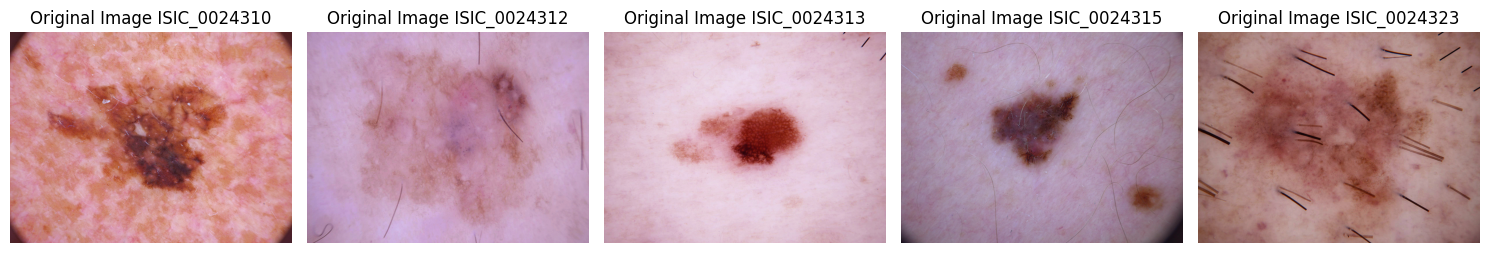

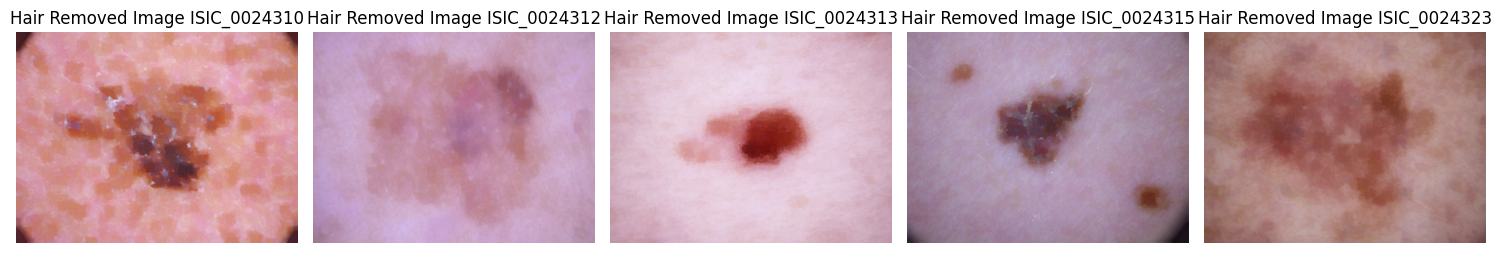

In [ ]:
def compare_images(path, title, image_id):
    plt.figure(figsize=(15, 7))
    for i, (path, image_id) in enumerate(zip(path, image_id), 1):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 5, i)
        plt.imshow(image)
        plt.title(f'{title} {image_id}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

image_path = merged_df['image_path'].tolist()[:5]
hair_removed_path = merged_df['hair_removed_path'].tolist()[:5]
image = merged_df['image'].tolist()[:5]

compare_images(image_path, 'Original Image', image)
compare_images(hair_removed_path, 'Hair Removed Image', image)



---


# 2- Testing the primatives


---



**2.1-** Test the Area and Diameter

In [ ]:
#See functions in primatives.py
from primatives import area, diameter, feret_diameter, feret_diameter2

In [ ]:
#Test the diameter primatives
mask_path = "/content/ham1000_dataset/filtered_images/ISIC_0024313.jpg"

area_mm = area(mask_path)
diameter_mm = diameter(area_mm)
feret_diameter_mm = feret_diameter(mask_path)
feret_diameter_mm2 = feret_diameter2(mask_path)

print("Mask Area in mm²:", area_mm)
print("Diameter in mm:", diameter_mm)
#Test the difference between two feret diameter calculation approaches
print("Feret Diameter:", feret_diameter_mm) #by directly computing the minimum and maximum x and y values from the contour points
print("Feret Diameter2:", feret_diameter_mm2) #by using the bounding rectangle of each contour

Mask Area in mm²: 51.86207561728395
Diameter in mm: 8.126059656929133
Feret Diameter: 10.397222593285237
Feret Diameter2: 8.333333333333334


**2.2-** Test Asymmetry

In [ ]:
#Test OSTU segmentation to use for calculating asymmetry, since it yielded decent result, we used it in the primatives functions to calculate convexity
#Original images (Not pre-processed to remove hair)
def otsu_segmentations(csv_path,image_path, num_images=5):
    df = pd.read_csv(csv_path)
    image_paths = df[image_path].tolist()[:num_images]
    image_ids = df['image'][:num_images]

    plt.figure(figsize=(15, 10))
    for i, (image_path, image_id) in enumerate(zip(image_paths, image_ids), 1):
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        _, threshold = cv2.threshold(gray, 0, 255, (cv2.THRESH_BINARY+cv2.THRESH_OTSU))

        plt.subplot(2, num_images, i)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image {image_id}')
        plt.axis('off')

        plt.subplot(2, num_images, i + num_images)
        plt.imshow(threshold, cmap='gray')
        plt.title(f'Segmented Image {image_id}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

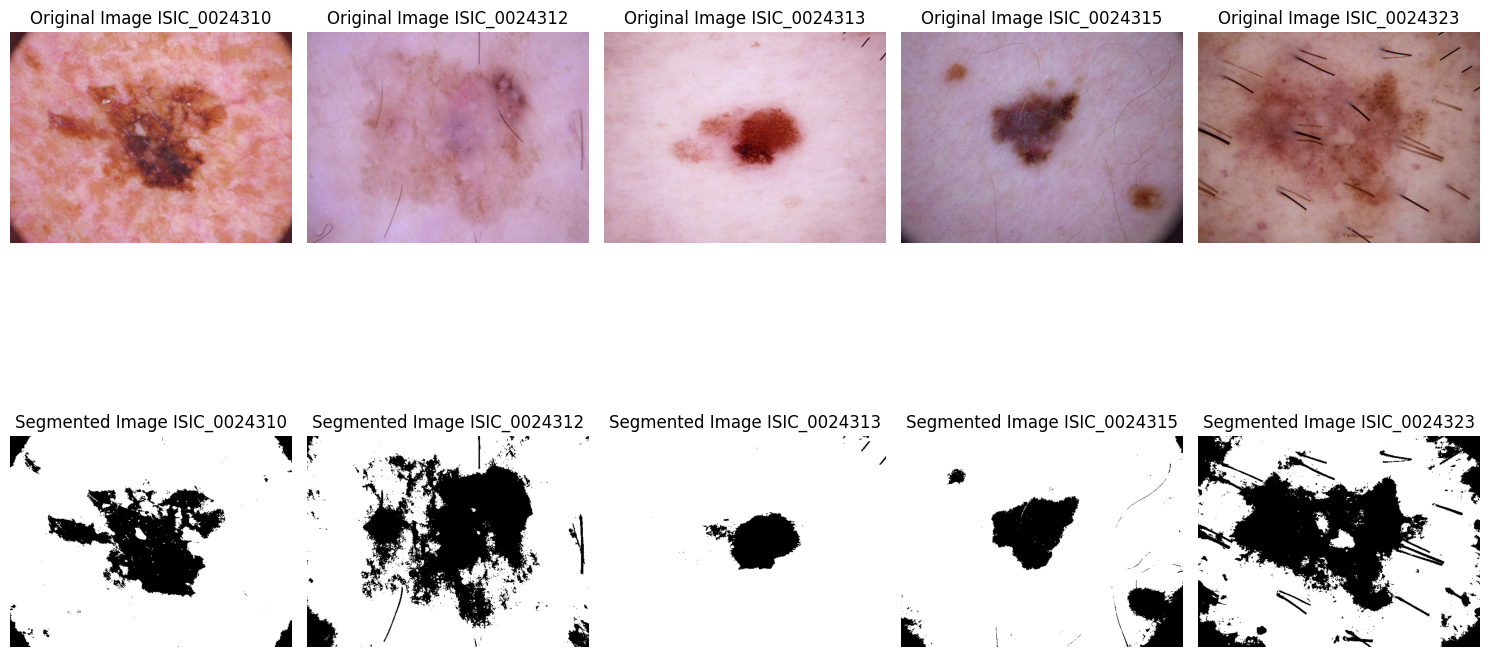

In [ ]:
#Try ostu on original images
csv_file_path = "/content/updated_image_and_metadata.csv"
image_path = 'image_path'
otsu_segmentations(csv_file_path, image_path)

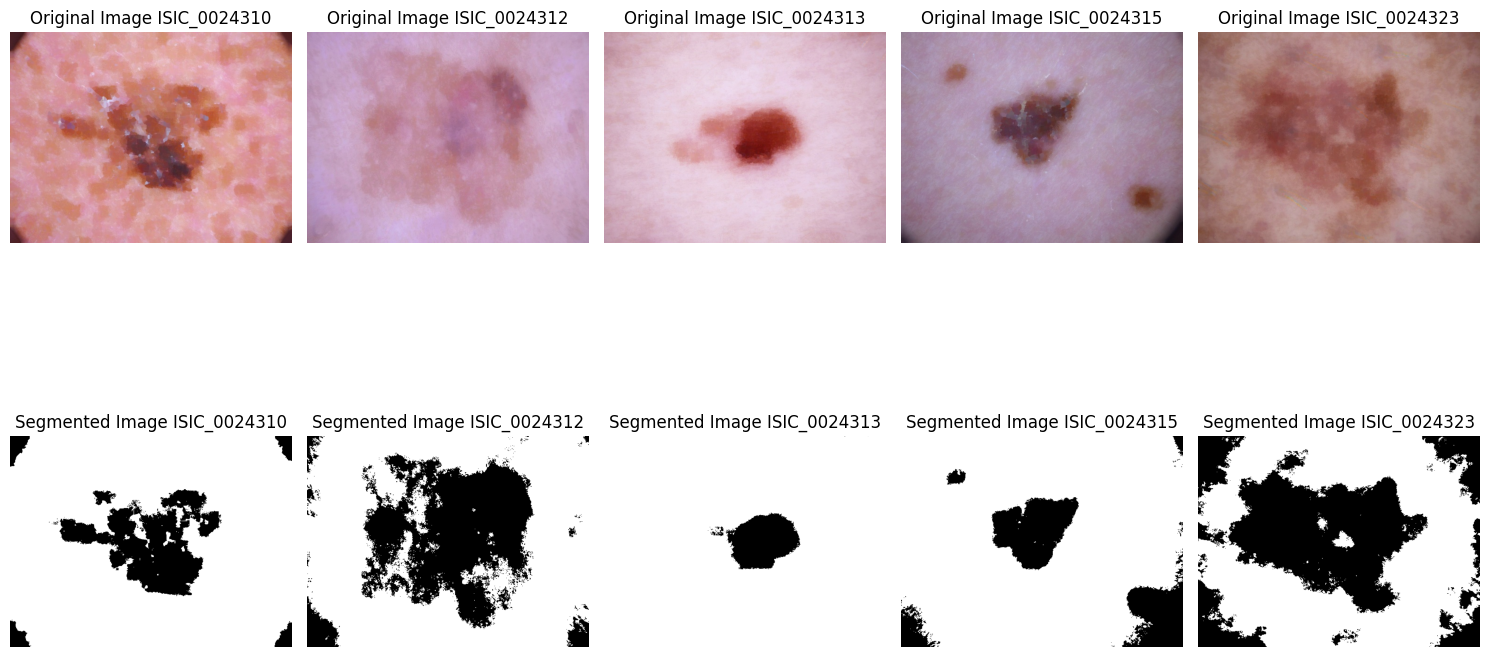

In [ ]:
#Since the previous threshold is sensitive to hair, we applied the otsu segemntation to the hair removed images
#Try ostu on hair removed images
hair_removed_image_path = 'hair_removed_path'
otsu_segmentations(csv_file_path, hair_removed_image_path)

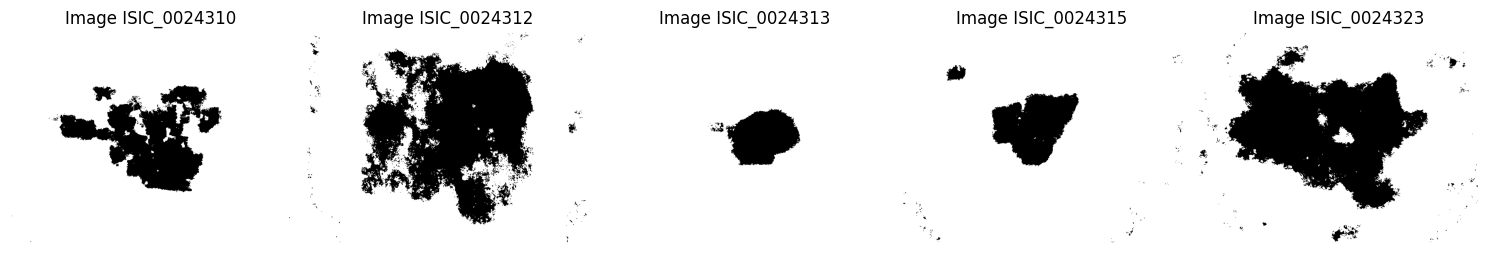

In [ ]:
#Since the borders are still in the segmented image this is an update to the previous method to remove the borders observed
def otsu_segmentations_no_hair_no_border(csv_path, num_images=5):
    df = pd.read_csv(csv_path)
    image_paths = df['hair_removed_path'].tolist()[:num_images]
    image_ids = df['image'][:num_images]

    plt.figure(figsize=(15, 10))
    for i, (image_path, image_id) in enumerate(zip(image_paths, image_ids), 1):
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        _, threshold = cv2.threshold(gray, 0, 255, (cv2.THRESH_BINARY+cv2.THRESH_OTSU))
        contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            max_contour = max(contours, key=cv2.contourArea)
            mask = np.zeros_like(threshold)
            cv2.drawContours(mask, [max_contour], -1, (255), thickness=cv2.FILLED)

            segmented_lesion = cv2.bitwise_and(threshold, mask)
            inverted_mask = cv2.bitwise_not(mask)
            ex_area = cv2.bitwise_xor(segmented_lesion, inverted_mask)

            plt.subplot(2, 5, i)
            plt.imshow(ex_area, cmap='gray')
            plt.title(f'Image {image_id}')
            plt.axis('off')
        else:
            plt.subplot(2, 5, i)
            plt.imshow(threshold, cmap='gray')
            plt.title(f'Image {image_id}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

csv_file_path = "/content/updated_image_and_metadata.csv"
otsu_segmentations_no_hair_no_border(csv_file_path)

In [ ]:
#Naive approach of getting the convexity defects (Based on the original images without pre-processing)
def naive_asymmetry_convexity_defects(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, threshold = cv2.threshold(gray, 0, 255, (cv2.THRESH_BINARY + cv2.THRESH_OTSU))
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        max_contour = max(contours, key=cv2.contourArea)

        hull = cv2.convexHull(max_contour, returnPoints=False)
        defects = cv2.convexityDefects(max_contour, hull)

        if defects is not None and len(defects) > 13:  #Threshold set to 13 by trial and error
            return "Asymmetric"
        else:
            return "Symmetric"
    else:
        return "Symmetric" #if no contours

In [ ]:
#Test for a sample
csv_file_path = '/content/updated_image_and_metadata.csv'
data = pd.read_csv(csv_file_path)

count = 0

for index, row in data.iterrows():
    if count >= 10:
        break

    image_path = row['image_path']
    try:
        symmetry_type = naive_asymmetry_convexity_defects(image_path)
        print(f"Symmetry: {symmetry_type}")
    except Exception as e:
        print(f"Error processing image at {image_path}: {str(e)}")
        symmetry_type = "ignored"

    count += 1

Symmetry: Asymmetric
Symmetry: Symmetric
Symmetry: Symmetric
Symmetry: Asymmetric
Symmetry: Asymmetric
Symmetry: Symmetric
Symmetry: Asymmetric
Symmetry: Asymmetric
Symmetry: Symmetric
Symmetry: Asymmetric


In [ ]:
#Since the segmentation yeilded descent results, we used it to infer the convexity defects (This one includes removing the borders)
from primatives import asymmetry_convexity_defects

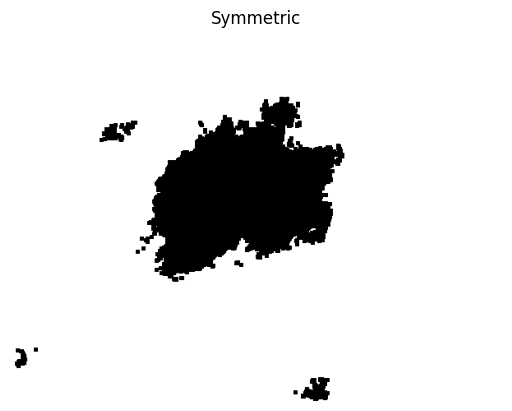

In [ ]:
result, symmetry_type = asymmetry_convexity_defects("/content/ham1000_dataset/hair_removed_images/hair_removed_ISIC_0024324.jpg") #Random sample of bkl image
plt.imshow(result, cmap='gray')
plt.title(f'{symmetry_type}')
plt.axis('off')
plt.show()

In [ ]:
#Test for a sample
csv_file_path = '/content/updated_image_and_metadata.csv'
data = pd.read_csv(csv_file_path)

count = 0

for index, row in data.iterrows():
    if count >= 10:
        break

    image_path = row['hair_removed_path'] #We pass the pre-processed data here for comparisant between naive and this method
    try:
        result, symmetry_type = asymmetry_convexity_defects(image_path)
        print(f"Symmetry: {symmetry_type}")
    except Exception as e:
        print(f"Error processing image at {image_path}: {str(e)}")
        symmetry_type = "ignored"

    count += 1

Symmetry: Asymmetric
Symmetry: Asymmetric
Symmetry: Symmetric
Symmetry: Asymmetric
Symmetry: Asymmetric
Symmetry: Symmetric
Symmetry: Asymmetric
Symmetry: Asymmetric
Symmetry: Asymmetric
Symmetry: Asymmetric


In [ ]:
#Another variant of calculating symmetry
def is_symmetric(image_path, mask_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img.shape[0] == 0 or img.shape[1] == 0:
            print(f"Error: Invalid image dimensions for {image_path}. Skipping.")
            return None
        _, binary_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            print(f"Error: No contour found for {image_path}. Skipping.")
            return None

        main_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(main_contour)

        # Ensure the bounding box dimensions are valid
        if w == 0 or h == 0:
            print(f"Error: Invalid bounding box dimensions for {image_path}. Skipping.")
            return None

        left_half = binary_image[y:y+h, x:int(x+w/2)].astype(np.float64)
        right_half = binary_image[y:y+h, int(x+w/2):x+w].astype(np.float64)

        if left_half.size == 0 or right_half.size == 0:
            print(f"Error: Invalid cropped halves for {image_path}. Skipping.")
            return None

        right_half_flipped = cv2.flip(right_half, 1)

        #Compare both halves
        difference = cv2.absdiff(left_half, right_half_flipped)
        similarity_score = np.sum(difference) / np.size(left_half)

        #print(f"Similarity Score: {similarity_score}")
        threshold = 12
        is_symmetric_result = similarity_score < threshold

        if is_symmetric_result:
            return "Symmetric"
        else:
            return "Asymmetric"

    except Exception as e:
        print(f"Error: {e}. Unable to process {image_path} or {mask_path}.")
        return None

**2.3**- Test Variation

In [ ]:
#Based on entropy: In the context of segmented skin lesions, entropy measures the randomness or disorder within the pixel intensity values of the segmented region.
from primatives import variance, variance_whole

In [ ]:
#Test variance
random_mel_image_path = "/content/ham1000_dataset/filtered_images/ISIC_0024310.jpg"
random_mel_mask_path = "/content/ham1000_dataset/filtered_masks/ISIC_0024310_segmentation.png"

random_blk_image_path = "/content/ham1000_dataset/filtered_images/ISIC_0024324.jpg"
random_blk_mask_path = "/content/ham1000_dataset/filtered_masks/ISIC_0024324_segmentation.png"

variance_mel = variance(random_mel_image_path, random_mel_mask_path) #change to variance_whole to test (check primatives.py)
variance_blk = variance(random_blk_image_path, random_blk_mask_path) #change to variance_whole to test (check primatives.py)

print("Variance for MEL:", variance_mel)
print("Variance for BLK:", variance_blk)

Variance for MEL: 2794.228368278517
Variance for BLK: 1933.0111927683959


**2.4-** Color variance (LAB image)

In [ ]:
from primatives import masked_image, lab_image

**2.5-** Histogram of Masked Areas (To infer the variance of color within the maked areas, so we could use it as a heuristic within the labeling functions if proved as useful information after applying the labeling functions to the data)

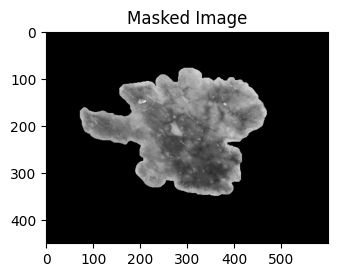

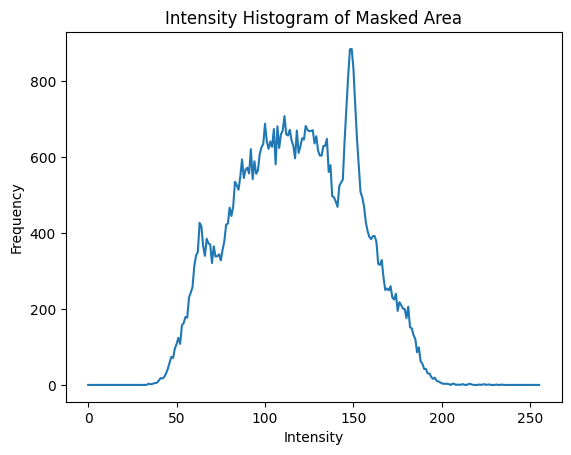

In [ ]:
#greyscale
def calculate_intensity_histogram(image_path, mask_path):
    dermoscopy_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    masked_img = cv2.bitwise_and(dermoscopy_img, dermoscopy_img, mask=mask)
    masked_intensity_hist = cv2.calcHist([masked_img], [0], mask, [256], [0, 256])

    return masked_img, masked_intensity_hist

image_path = "/content/ham1000_dataset/filtered_images/ISIC_0024310.jpg" #Random mel image
mask_path = "/content/ham1000_dataset/filtered_masks/ISIC_0024310_segmentation.png"

result = calculate_intensity_histogram(image_path, mask_path)

masked_img = result[0]
histogram = result[1]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(masked_img, cmap='gray')
plt.title('Masked Image')

plt.figure()
plt.title('Intensity Histogram of Masked Area')
plt.plot(histogram)
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

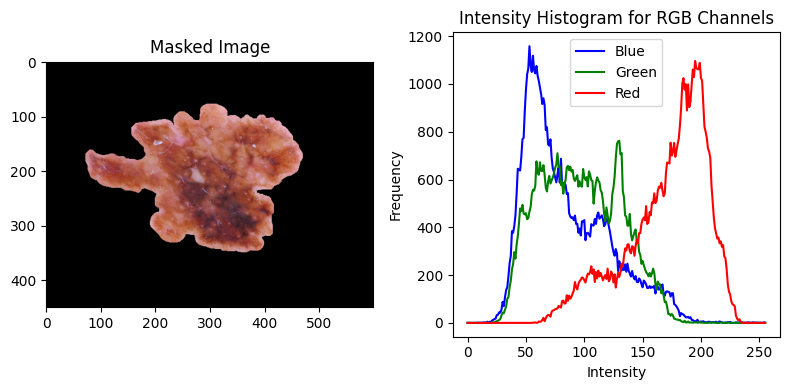

In [ ]:
#RGB
def calculate_intensity_histogram_RGB(image_path, mask_path):
    dermoscopy_img = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    masked_img = cv2.bitwise_and(dermoscopy_img, dermoscopy_img, mask=mask)
    b, g, r = cv2.split(masked_img)

    hist_b = cv2.calcHist([b], [0], mask, [256], [0, 256])
    hist_g = cv2.calcHist([g], [0], mask, [256], [0, 256])
    hist_r = cv2.calcHist([r], [0], mask, [256], [0, 256])

    return masked_img, hist_b, hist_g, hist_r

#Sample of an MEL img
image_path = "/content/ham1000_dataset/filtered_images/ISIC_0024310.jpg" #Random mel image
mask_path = "/content/ham1000_dataset/filtered_masks/ISIC_0024310_segmentation.png"

result = calculate_intensity_histogram_RGB(image_path, mask_path)

masked_img = result[0]
hist_b = result[1]
hist_g = result[2]
hist_r = result[3]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.title('Masked Image')

plt.subplot(1, 2, 2)
plt.plot(hist_b, color='blue', label='Blue')
plt.plot(hist_g, color='green', label='Green')
plt.plot(hist_r, color='red', label='Red')
plt.title('Intensity Histogram for RGB Channels')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

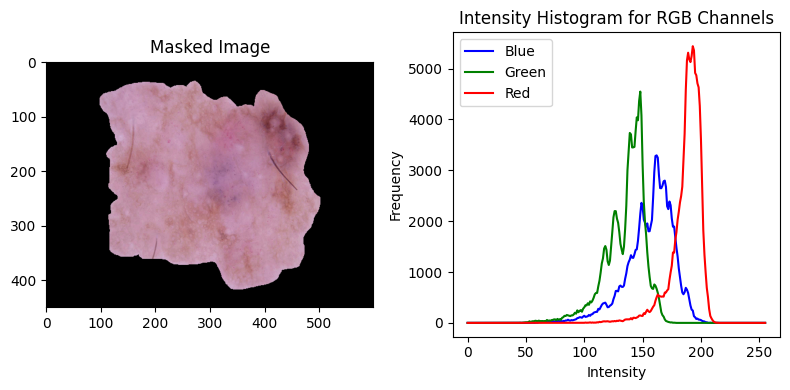

In [ ]:
#Sample of a BKL img
image_path = "/content/ham1000_dataset/filtered_images/ISIC_0024312.jpg" #Random bkl image
mask_path = "/content/ham1000_dataset/filtered_masks/ISIC_0024312_segmentation.png"

result = calculate_intensity_histogram_RGB(image_path, mask_path)

masked_img = result[0]
hist_b = result[1]
hist_g = result[2]
hist_r = result[3]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.title('Masked Image')

plt.subplot(1, 2, 2)
plt.plot(hist_b, color='blue', label='Blue')
plt.plot(hist_g, color='green', label='Green')
plt.plot(hist_r, color='red', label='Red')
plt.title('Intensity Histogram for RGB Channels')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()



---
# 3- Weak Supervision: Labeling Functions


---




Labels of interest

In [ ]:
mel = 1
bkl = -1
ABSTAIN = 0
#operate on merged_df

Generating the noisy labels



---
*3.1- Labeling Functions (Over Metadata, considered noisy sources)*

---




In [ ]:
#Under the assumption of Acral lentiginous melanoma (ALM), which is a specific type of melanoma that appears on the palms of the hands, the soles of the feet
#Under the assumption that Actinic keratoses (benign) are very common on sites repeatedly exposed to the sun, for example face
#Benign lipomas, epidermoid cysts and sebaceous cysts remain as the most common diagnoses.
@labeling_function()
def lf_localization(x):
  if x.localization == 'foot':
    return mel
  elif x.localization == 'face' or 'scalp':
    return bkl
  else:
    return ABSTAIN

In [ ]:
#Under the assumption that going for an invasive procedure like histo it implies that there is uncertainity and high chance it being a melanoma, otherwise, going only for non-invasive methods without going to histo may imply that it is a benign tumor
@labeling_function()
def lf_checkup(x):
  if x.dx_type == 'histo':
    return mel
  elif x.dx_type == 'consensus':
    return bkl
  elif x.dx_type == 'confocal':
    return bkl

In [ ]:
#The average age of people when it is diagnosed is 65
#On age related cancers, melanoma is the #3 most diagnosed cancer among individuals age 25 to 39 in the United States. For younger individuals ages 15 to 29, it is the 9th most common.
@labeling_function()
def lf_age(x):
  if x.age < 20:
    return bkl
  elif x.age >= 25 and x.age <= 39:
    return mel
  elif x.age >=65:
    return mel
  else:
    return bkl

https://scmsjournal.com/wp-content/uploads/2016/02/vol29_i4-Epidemiology.pdf

Age (0-40) and Female => Melanoma
Age (+40) and Male => Melanoma

In [ ]:
#Age (0-40) and Female => Melanoma
#Age (+40) and Male => Melanoma
@labeling_function()
def lf_age_gender(x):
    if (x.age <= 40 and x.sex == "female") or (x.age > 40 and x.sex == "male"):
        return mel
    else:
        return ABSTAIN

https://pubmed.ncbi.nlm.nih.gov/32645881/
Anatomic localization of melanoma differs between genders: it's more common on the trunk in men and on the lower limbs in women.

In [ ]:
#Anatomic localization of melanoma differs between genders: it's more common on the trunk in men and on the lower limbs in women.
@labeling_function()
def lf_gender_location(x):
    if x.sex == 'male' and x.localization == 'trunk':
        return mel
    elif x.sex == 'female' and x.localization == 'trunk':
        return bkl
    else:
        return ABSTAIN

In [ ]:
@labeling_function()
def lf_gender_location2(x):
    if x.sex == 'male' and (x.localization == 'trunk' or  x.localization == 'foot'):
        return mel
    elif x.sex == 'male' and (x.localization == 'upper extremity' or x.localization == 'chest'):
        return bkl
    elif x.sex == 'female' and (x.localization == 'trunk' or x.localization == 'face' or x.localization == 'hand' or x.localization == 'genital'):
        return bkl

    else:
        return ABSTAIN



---
*3.2- Labeling Functions (Over Area and Diameter)*


---



In [ ]:
#Diameter from area
#From ABCDE's of mel (D: diameter above 6 mm)
@labeling_function()
def dia(x):
    mask_path = x.mask_path
    ar = area(mask_path)
    diam = diameter(ar)
    if diam is not None and float(diam) > 6.0:
        return mel
    else:
        return ABSTAIN

In [ ]:
#Feret diameter
#From ABCDE's of mel (D: diameter above 6 mm)
@labeling_function()
def feret_dia(x):
    mask_path = x.mask_path
    diam = feret_diameter(mask_path)
    if diam is not None and float(diam) > 6.0:
        return mel
    else:
        return ABSTAIN

In [ ]:
#Combine feret and reg diameter (Noisy)
@labeling_function()
def combine_dia(x):
  mask_path = x.mask_path
  ar = area(mask_path)
  diam = diameter(ar)
  fer = feret_diameter(mask_path)

  if diam > 6 and fer > 6:
    return mel
  else:
    return bkl

---
*3.3- Labeling Functions (Over Asymmetry Testing)*


---

In [ ]:
@labeling_function()
def asymmetry2(x):
    image_path = x.image_path
    mask_path = x.mask_path

    result = is_symmetric(image_path, mask_path)
    if result == "Symmetric":
      return bkl
    elif result == "Asymmetric":
      return mel
    else:
      return ABSTAIN

In [ ]:
@labeling_function()
def asymmetry(x):
    image_path = x.hair_removed_path
    try:
        result, symmetry_type = asymmetry_convexity_defects(image_path)
        if symmetry_type == "Symmetric":
            return bkl
        elif symmetry_type == "Asymmetric":
            return mel
    except Exception as e:
        print(f"Error processing image at {image_path}: {str(e)}")
        return ABSTAIN

In [ ]:
@labeling_function()
def asymmetry_naive(x):
    image_path = x.image_path
    try:
        symmetry_type = naive_asymmetry_convexity_defects(image_path)
        if symmetry_type == "Symmetric":
            return bkl
        elif symmetry_type == "Asymmetric":
            return mel
    except Exception as e:
        print(f"Error processing image at {image_path}: {str(e)}")
        return ABSTAIN


---
*3.4- Labeling Functions (Over varaition)*


---

In [ ]:
#Entropy
threshold = 3200 #by trial and error
@labeling_function()
def variance_labeling(x):
    var = variance(x.hair_removed_path, x.mask_path)
    if var > threshold:
        return mel
    else:
        return bkl

In [ ]:
#Entropy
threshold2 = 300 #by trial and error
@labeling_function()
def variance_whole_image(x):
    var = variance_whole(x.hair_removed_path)
    if var < threshold2:
        return bkl
    else:
        return mel

In [ ]:
@labeling_function()
def label_skin_lesion(x):
    masked_img= masked_image(x.hair_removed_path, x.mask_path)

    lab = cv2.cvtColor(masked_img, cv2.COLOR_BGR2LAB)
    avg_l, avg_a, avg_b = lab_image(lab)

    if avg_a > 120 and avg_b > 130: #Thresholds set after trial and error
        return mel
    else:
        return bkl



---

**3.5-** Applier of Labeling Functions

---



In [ ]:
lfs = [lf_localization, lf_checkup, combine_dia, lf_gender_location,asymmetry2, label_skin_lesion, lf_age_gender, dia] #Fixed this combination of Labeling Functions as they showcased the best agreement using majority vote
applier = PandasLFApplier(lfs = lfs)
L_train = applier.apply(df = merged_df)

In [ ]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_localization,0,[1],0.013110,0.013110,0.013110
lf_checkup,1,[1],0.849458,0.849458,0.846745
combine_dia,2,[1],0.139241,0.139241,0.133816
lf_gender_location,3,"[0, 1]",0.981465,0.981465,0.962025
asymmetry2,4,"[0, 1]",0.867993,0.867993,0.855335
label_skin_lesion,5,[1],0.139693,0.139693,0.138336
lf_age_gender,6,"[0, 1]",1.000000,1.000000,0.979656
dia,7,"[0, 1]",1.000000,1.000000,0.979656


In [ ]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [ ]:
preds_train[:100]

array([ 1,  1,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  1,  1,  1, -1,  0,
       -1,  0,  0,  0,  0,  1, -1,  1, -1,  1,  1,  1,  0,  1,  1,  1,  0,
        1,  1,  1,  0,  0,  0,  0,  1,  0,  1,  1,  0,  0,  1,  0, -1,  1,
       -1,  0,  1,  0, -1,  1,  0,  1,  1,  0,  1,  0,  1,  1,  0,  1,  0,
        0,  1,  1,  1,  1,  0,  1,  0,  1,  0,  1,  1,  0,  0,  1,  1, -1,
        1,  1,  1,  0, -1,  1,  1, -1,  1,  1, -1,  0,  1,  1,  1])

In [ ]:
#Test majority vote
csv_file_path = '/content/ham1000_dataset/filtered_groundtruth.csv'
original_data = pd.read_csv(csv_file_path)

predictions = preds_train
label_map = {0: 'ABSTAIN', 1: 'MEL', -1: 'BKL'}
str_preds = [label_map[pred] for pred in predictions]

compare = pd.DataFrame({'class': original_data['class'], 'pred': predictions, 'str_pred': str_preds})

In [ ]:
#Ratio of abstaining
class_counts = compare['class'].value_counts()
str_pred_counts = compare['str_pred'].value_counts()

total_samples = len(compare)
abstain_percentage = (str_pred_counts['ABSTAIN'] / total_samples) * 100

print("Counts in 'class' column:")
print(class_counts)

print("\nCounts in 'str_pred' column:")
print(str_pred_counts)

print(f"\nPercentage of ABSTAIN in 'str_pred': {abstain_percentage:.2f}%")

Counts in 'class' column:
MEL    1113
BKL    1099
Name: class, dtype: int64

Counts in 'str_pred' column:
MEL        1180
ABSTAIN     763
BKL         269
Name: str_pred, dtype: int64

Percentage of ABSTAIN in 'str_pred': 34.49%


In [ ]:
filtered_compare = compare[compare['str_pred'] != 'ABSTAIN']

correct_bkl = len(filtered_compare[(filtered_compare['class'] == 'BKL') & (filtered_compare['str_pred'] == 'BKL')])
correct_mel = len(filtered_compare[(filtered_compare['class'] == 'MEL') & (filtered_compare['str_pred'] == 'MEL')])

In [ ]:
total_bkl = len(filtered_compare[filtered_compare['class'] == 'BKL'])
total_mel = len(filtered_compare[filtered_compare['class'] == 'MEL'])

percentage_correct_bkl = (correct_bkl / total_bkl) * 100 if total_bkl > 0 else 0
percentage_correct_mel = (correct_mel / total_mel) * 100 if total_mel > 0 else 0

print(f"Percentage of correctly predicted BKL (excluding ABSTAIN): {percentage_correct_bkl:.2f}%")
print(f"Percentage of correctly predicted MEL (excluding ABSTAIN): {percentage_correct_mel:.2f}%")

Percentage of correctly predicted BKL (excluding ABSTAIN): 27.33%
Percentage of correctly predicted MEL (excluding ABSTAIN): 88.89%


In [ ]:
def calculate_similarity(dataframe, col1, col2):
    matches = sum((dataframe[col1] == dataframe[col2]) & (dataframe[col2] != 'ABSTAIN'))
    total_samples = len(dataframe[dataframe[col2] != 'ABSTAIN'])
    similarity = matches / total_samples
    return similarity

similarity_accuracy = calculate_similarity(compare, 'class', 'str_pred')
print(f"Similarity (Accuracy): {similarity_accuracy}")

Similarity (Accuracy): 0.6059351276742581


Classification Report:
              precision    recall  f1-score   support

         BKL       0.68      0.27      0.39       666
         MEL       0.59      0.89      0.71       783

    accuracy                           0.61      1449
   macro avg       0.63      0.58      0.55      1449
weighted avg       0.63      0.61      0.56      1449



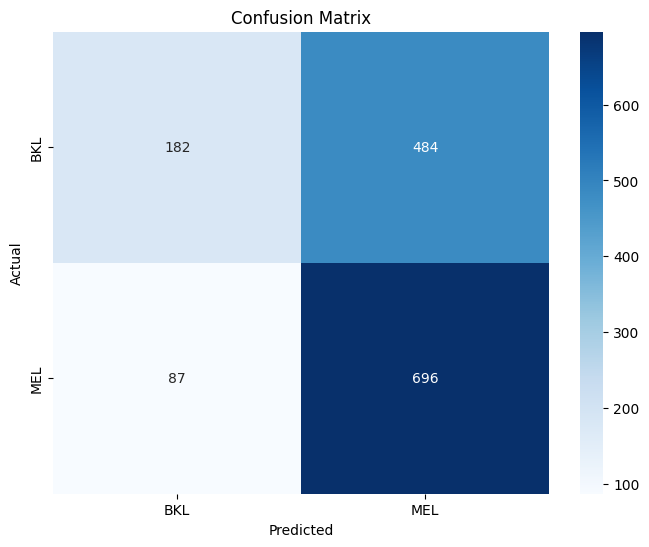

In [ ]:
classification_rep = classification_report(filtered_compare['class'],
                                           filtered_compare['str_pred'])

conf_matrix = confusion_matrix(filtered_compare['class'],
                               filtered_compare['str_pred'])

print("Classification Report:")
print(classification_rep)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['BKL', 'MEL'], yticklabels=['BKL', 'MEL'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can infer that majority labeler is identifying mel images and labeling them correctly far more than the bkl images. This can be seen due to the primatives being based over clinical observations over melanoma cases like the ABCDs.

In [ ]:
#Try generative model
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

100%|██████████| 500/500 [00:00<00:00, 856.19epoch/s]


In [ ]:
probs_train = label_model.predict_proba(L_train)
predicted_labels = label_model.predict(L_train)

In [ ]:
label_model_predictions = predicted_labels
label_map = {0: 'ABSTAIN', 1: 'MEL', -1: 'BKL'}
str_label_model_preds = [label_map[pred] for pred in label_model_predictions]

compare_label_model = pd.DataFrame({'class': original_data['class'], 'pred_label_model': label_model_predictions, 'str_pred_label_model': str_label_model_preds})

In [ ]:
similarity_accuracy_label_model = calculate_similarity(compare_label_model, 'class', 'str_pred_label_model')
print(f"Similarity (Accuracy) for LabelModel: {similarity_accuracy_label_model}")

Similarity (Accuracy) for LabelModel: 0.44565217391304346


Conclusion: Majority vote yielded better results than Model Label (generative model)



---
# 4- Weak Supervision: Second round of weak supervision to cover ABSTAIN case


---

In [ ]:
#Filter out the images that got ABSTAIN
second_round = compare.copy()
image_metadata_path = '/content/updated_image_and_metadata.csv'
image_metadata = pd.read_csv(image_metadata_path)

second_round['image'] = image_metadata['image']
abstain_rows = second_round[second_round['str_pred'] == 'ABSTAIN']
print(abstain_rows.head())

   class  pred str_pred         image
2    MEL     0  ABSTAIN  ISIC_0024313
7    BKL     0  ABSTAIN  ISIC_0024336
8    BKL     0  ABSTAIN  ISIC_0024337
9    BKL     0  ABSTAIN  ISIC_0024338
10   MEL     0  ABSTAIN  ISIC_0024351


In [ ]:
#Append the metadata so that we can apply a second round of weak supervision over the metadata
columns_to_merge = ['dx_type', 'age', 'sex', 'localization']
merged_abstain_rows = pd.merge(abstain_rows, image_metadata[columns_to_merge + ['image']], on='image', how='left')

print(merged_abstain_rows.head())

  class  pred str_pred         image    dx_type   age     sex     localization
0   MEL     0  ABSTAIN  ISIC_0024313      histo  50.0  female             back
1   BKL     0  ABSTAIN  ISIC_0024336      histo  50.0  female  lower extremity
2   BKL     0  ABSTAIN  ISIC_0024337  consensus  50.0  female  lower extremity
3   BKL     0  ABSTAIN  ISIC_0024338      histo  45.0  female             face
4   MEL     0  ABSTAIN  ISIC_0024351      histo  70.0  female  lower extremity


In [ ]:
merged_abstain_rows.to_csv('/content/merged_abstain_rows.csv', index=False)



---


**4.1-** Labeling functions


---



In [ ]:
@labeling_function()
def second_round_lf_checkup(x):
  if x.dx_type == 'consensus' or x.dx_type == 'confocal': #Since histo is invasive, it implies the concern about it being truley mel
    return bkl
  else:
    return ABSTAIN

In [ ]:
@labeling_function()
def not_exposed_to_sun(x): #Parts not exposed to the sun are more likely to not develop malignant growths
  if x.localization == 'abdomen' or x.localization == 'chest' or x.localization == 'trunk':
    return bkl
  else:
    return mel

In [ ]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5773794/
@labeling_function()
def gender_localization_stats(x):
  if x.localization == 'lower extremity' and x.sex == 'female':
    return mel
  else:
    return bkl

In [ ]:
#In the cases that we have unknowns, throw them as blk (Noisy source that might influencce the majority vote labeler)
@labeling_function()
def unknowns(x):
  if x.localization == 'unknown' or x.sex == 'unknown':
    return bkl
  else:
    return ABSTAIN

In [ ]:
@labeling_function()
def histo(x): #Adding randomness
  if x.dx_type == 'histo' and x.sex == 'female':
    return mel
  else:
    return bkl

In [ ]:
secondround_lfs = [second_round_lf_checkup,not_exposed_to_sun,gender_localization_stats,unknowns, histo]
secondround_applier = PandasLFApplier(lfs = secondround_lfs)
secondround_L_train = secondround_applier.apply(df = merged_abstain_rows)

100%|██████████| 763/763 [00:00<00:00, 15388.50it/s]


In [ ]:
LFAnalysis(L=secondround_L_train, lfs=secondround_lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
second_round_lf_checkup,0,[0],0.769332,0.769332,0.744430
not_exposed_to_sun,1,[1],0.875491,0.857143,0.857143
gender_localization_stats,2,[1],0.201835,0.201835,0.201835
unknowns,3,[0],0.979030,0.923984,0.899083
histo,4,[1],0.602883,0.602883,0.602883


In [ ]:
secondround_majority_model = MajorityLabelVoter()
secondround_preds_train = secondround_majority_model.predict(L=secondround_L_train)

In [ ]:
#Test majority vote
csv_file_path = '/content/merged_abstain_rows.csv'
second_round_original_data = pd.read_csv(csv_file_path)

secondround_predictions = secondround_preds_train
label_map = {0: 'ABSTAIN', 1: 'MEL', -1: 'BKL'}
str_preds = [label_map[pred] for pred in secondround_predictions]

secondround_compare = pd.DataFrame({'class': second_round_original_data['class'], 'pred': secondround_predictions, 'str_pred': str_preds})
secondround_compare.head()

,class,pred,str_pred
0,MEL,-1,BKL
1,BKL,1,MEL
2,BKL,1,MEL
3,BKL,-1,BKL
4,MEL,1,MEL


In [ ]:
#Ratio of abstaining
class_counts = secondround_compare['class'].value_counts()
str_pred_counts = secondround_compare['str_pred'].value_counts()

total_samples = len(secondround_compare)
abstain_percentage = (str_pred_counts['ABSTAIN'] / total_samples) * 100


print("Counts in 'class' column:")
print(class_counts)

print("\nCounts in 'str_pred' column:")
print(str_pred_counts)

print(f"\nPercentage of ABSTAIN in 'str_pred': {abstain_percentage:.2f}%")

Counts in 'class' column:
BKL    433
MEL    330
Name: class, dtype: int64

Counts in 'str_pred' column:
BKL        392
ABSTAIN    202
MEL        169
Name: str_pred, dtype: int64

Percentage of ABSTAIN in 'str_pred': 26.47%


In [ ]:
secondround_filtered_compare = secondround_compare[secondround_compare['str_pred'] != 'ABSTAIN']

correct_bkl = len(secondround_filtered_compare[(secondround_filtered_compare['class'] == 'BKL') & (secondround_filtered_compare['str_pred'] == 'BKL')])
correct_mel = len(secondround_filtered_compare[(secondround_filtered_compare['class'] == 'MEL') & (secondround_filtered_compare['str_pred'] == 'MEL')])

In [ ]:
total_bkl = len(secondround_filtered_compare[secondround_filtered_compare['class'] == 'BKL'])
total_mel = len(secondround_filtered_compare[secondround_filtered_compare['class'] == 'MEL'])

percentage_correct_bkl = (correct_bkl / total_bkl) * 100 if total_bkl > 0 else 0
percentage_correct_mel = (correct_mel / total_mel) * 100 if total_mel > 0 else 0

print(f"Percentage of correctly predicted BKL (excluding ABSTAIN): {percentage_correct_bkl:.2f}%")
print(f"Percentage of correctly predicted MEL (excluding ABSTAIN): {percentage_correct_mel:.2f}%")

Percentage of correctly predicted BKL (excluding ABSTAIN): 72.76%
Percentage of correctly predicted MEL (excluding ABSTAIN): 34.03%


In [ ]:
secondround_similarity_accuracy = calculate_similarity(secondround_compare, 'class', 'str_pred')
print(f"Similarity (Accuracy): {secondround_similarity_accuracy}")

Similarity (Accuracy): 0.5632798573975044


Classification Report:
              precision    recall  f1-score   support

         BKL       0.60      0.73      0.66       323
         MEL       0.48      0.34      0.40       238

    accuracy                           0.56       561
   macro avg       0.54      0.53      0.53       561
weighted avg       0.55      0.56      0.55       561



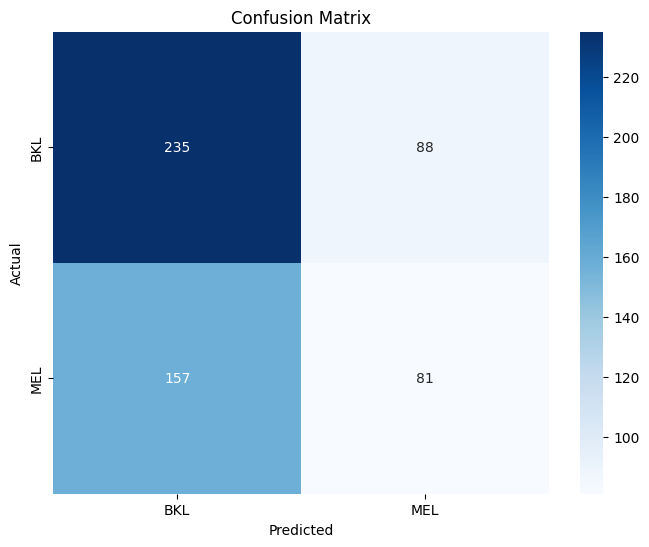

In [ ]:
classification_rep = classification_report(secondround_filtered_compare['class'],
                                           secondround_filtered_compare['str_pred'])

conf_matrix = confusion_matrix(secondround_filtered_compare['class'],
                               secondround_filtered_compare['str_pred'])

print("Classification Report:")
print(classification_rep)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['BKL', 'MEL'], yticklabels=['BKL', 'MEL'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

---
# 5- Weak Supervision: Neseted Weak Supervision (Combining the result of the rounds)


---

In [ ]:
#Update the str_pred to the results of the second round
updated_rows = abstain_rows.copy()

In [ ]:
str_pred_secondround = secondround_compare['str_pred'].tolist()
str_pred_updated = updated_rows['str_pred'].tolist()

min_len = min(len(str_pred_secondround), len(str_pred_updated))
updated_rows['str_pred'][:min_len] = str_pred_secondround[:min_len] #since the IDs are not equal in both dfs, but the relative position is

updated_rows[:10]

<ipython-input-274-fffc3cf43aee>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_rows['str_pred'][:min_len] = str_pred_secondround[:min_len] #since the IDs are not equal in both dfs, but the relative position is


,class,pred,str_pred,image
2,MEL,0,BKL,ISIC_0024313
7,BKL,0,MEL,ISIC_0024336
8,BKL,0,MEL,ISIC_0024337
9,BKL,0,BKL,ISIC_0024338
10,MEL,0,MEL,ISIC_0024351
11,BKL,0,BKL,ISIC_0024358
16,BKL,0,ABSTAIN,ISIC_0024383
18,BKL,0,BKL,ISIC_0024408
19,BKL,0,BKL,ISIC_0024409
20,MEL,0,ABSTAIN,ISIC_0024410


In [ ]:
full_compare = compare.copy()
full_compare.update(updated_rows)

In [ ]:
full_compare[:65] #To double check that it has updated it correctly

,class,pred,str_pred
0,MEL,1.0,MEL
1,BKL,1.0,MEL
2,MEL,0.0,BKL
3,MEL,1.0,MEL
4,MEL,1.0,MEL
...,...,...,...
60,BKL,0.0,BKL
61,MEL,1.0,MEL
62,BKL,0.0,ABSTAIN
63,MEL,1.0,MEL


In [ ]:
len(full_compare)

2212

Now we can check the ratios and accuracies of the final nested weak supervision (Results of first round + Results of the second round)

In [ ]:
#Ratio of abstaining
class_counts = full_compare['class'].value_counts()
str_pred_counts = full_compare['str_pred'].value_counts()

total_samples = len(full_compare)
abstain_percentage = (str_pred_counts['ABSTAIN'] / total_samples) * 100

#Comment here
print("Counts in 'class' column:")
print(class_counts)

print("\nCounts in 'str_pred' column:")
print(str_pred_counts)
#To here

print(f"\nPercentage of ABSTAIN in 'str_pred': {abstain_percentage:.2f}%")

Counts in 'class' column:
MEL    1113
BKL    1099
Name: class, dtype: int64

Counts in 'str_pred' column:
MEL        1349
BKL         661
ABSTAIN     202
Name: str_pred, dtype: int64

Percentage of ABSTAIN in 'str_pred': 9.13%


In [ ]:
finalround_full_compare = full_compare[full_compare['str_pred'] != 'ABSTAIN']

correct_bkl = len(finalround_full_compare[(finalround_full_compare['class'] == 'BKL') & (finalround_full_compare['str_pred'] == 'BKL')])
correct_mel = len(finalround_full_compare[(finalround_full_compare['class'] == 'MEL') & (finalround_full_compare['str_pred'] == 'MEL')])

In [ ]:
total_bkl = len(finalround_full_compare[finalround_full_compare['class'] == 'BKL'])
total_mel = len(finalround_full_compare[finalround_full_compare['class'] == 'MEL'])

percentage_correct_bkl = (correct_bkl / total_bkl) * 100 if total_bkl > 0 else 0
percentage_correct_mel = (correct_mel / total_mel) * 100 if total_mel > 0 else 0

print(f"Percentage of correctly predicted BKL (excluding ABSTAIN): {percentage_correct_bkl:.2f}%")
print(f"Percentage of correctly predicted MEL (excluding ABSTAIN): {percentage_correct_mel:.2f}%")

Percentage of correctly predicted BKL (excluding ABSTAIN): 42.16%
Percentage of correctly predicted MEL (excluding ABSTAIN): 76.10%


In [ ]:
finalround_similarity_accuracy = calculate_similarity(full_compare, 'class', 'str_pred')
print(f"Similarity (Accuracy): {finalround_similarity_accuracy}")

Similarity (Accuracy): 0.5940298507462687


Classification Report:
              precision    recall  f1-score   support

         BKL       0.63      0.42      0.51       989
         MEL       0.58      0.76      0.66      1021

    accuracy                           0.59      2010
   macro avg       0.60      0.59      0.58      2010
weighted avg       0.60      0.59      0.58      2010



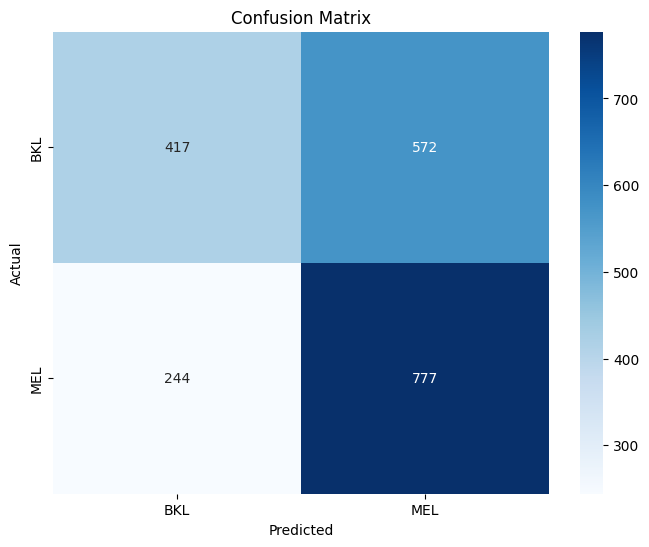

In [ ]:
classification_rep = classification_report(finalround_full_compare['class'],
                                           finalround_full_compare['str_pred'])

conf_matrix = confusion_matrix(finalround_full_compare['class'],
                               finalround_full_compare['str_pred'])

print("Classification Report:")
print(classification_rep)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['BKL', 'MEL'], yticklabels=['BKL', 'MEL'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()